In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(url, names=["SepalLength","SepalWidth","PetalLength","PetalWidth","Species"])
iris.sample(10)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
129,7.2,3.0,5.8,1.6,Iris-virginica
57,4.9,2.4,3.3,1.0,Iris-versicolor
4,5.0,3.6,1.4,0.2,Iris-setosa
76,6.8,2.8,4.8,1.4,Iris-versicolor
48,5.3,3.7,1.5,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa
88,5.6,3.0,4.1,1.3,Iris-versicolor
86,6.7,3.1,4.7,1.5,Iris-versicolor
55,5.7,2.8,4.5,1.3,Iris-versicolor
90,5.5,2.6,4.4,1.2,Iris-versicolor


In [3]:
iris.Species.value_counts()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

Distribution of the three classes (Species) in this problem is euqally distributed. Accuracy would a good measure of the performance for model evaluation.

In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLength    150 non-null float64
SepalWidth     150 non-null float64
PetalLength    150 non-null float64
PetalWidth     150 non-null float64
Species        150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


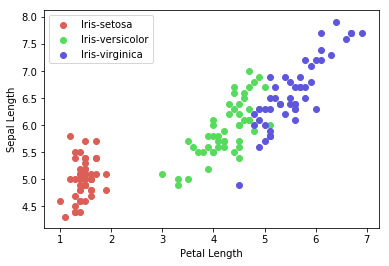

In [5]:
species = iris.Species.unique()
colors = sns.color_palette("hls", 3)
for i, v in enumerate(species):
    df = iris[iris.Species == v]
    plt.scatter(df["PetalLength"],df["SepalLength"], color = colors[i], label = v)
plt.legend(loc = "upper left")
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")

In [6]:
y = np.where(iris.Species == "Iris-virginica", 1, 0)

### Sigmoid Activation Function

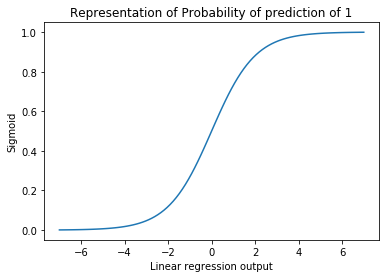

In [7]:
p = np.linspace(-7, 7, 100)
def phi(p):
    return 1 / (1 + np.exp(-p))
plt.plot(p, phi(p))
plt.xlabel("Linear regression output")
plt.ylabel("Sigmoid")
plt.title("Representation of Probability of prediction of 1")

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

from mlxtend.plotting import plot_decision_regions

In [9]:
X = iris.iloc[:, [2, 0]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 340)
X_train.shape

(105, 2)

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
outcome = pd.DataFrame({"actual": y_test,"pred": y_test_pred}) 
outcome["match"] = outcome.actual == outcome.pred
outcome.sample(10)

,actual,pred,match
24,1,1,True
38,0,0,True
42,1,1,True
27,1,0,False
8,0,0,True
3,1,1,True
16,0,0,True
11,0,0,True
0,0,0,True
34,0,0,True


In [11]:
accuracy_score(y_test, y_test_pred)

0.91111111111111109

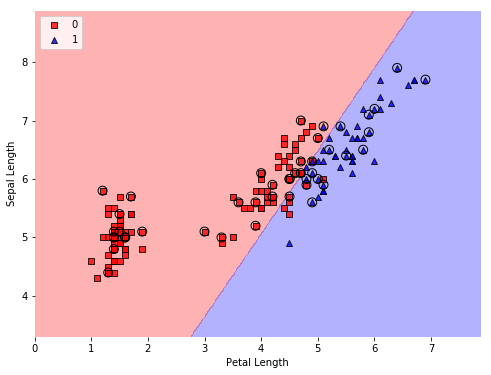

In [12]:
plt.figure(figsize=(8, 6))
plot_decision_regions(X, y, lr, X_highlight = X_test)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")

In [13]:
confusion_matrix(y_test, y_test_pred)

array([[27,  3],
       [ 1, 14]])

In [14]:
accuracy_score(y_test, y_test_pred)

0.91111111111111109

By default, the positive probability > 0.5 is outcome as 1 else 0. What if we want to change the probabilities threshold.

In [15]:
y_test_prob = lr.predict_proba(X_test)[:, 1]
y_test_pred_new = np.where(y_test_prob > 0.8, 1, 0)
print("Accuracy: ", accuracy_score(y_test, y_test_pred_new))
confusion_matrix(y_test, y_test_pred_new)

Accuracy:  0.8


array([[30,  0],
       [ 9,  6]])

So we can observe that as we vary the threshold the accuracy score varies too. But who decides on threshold?

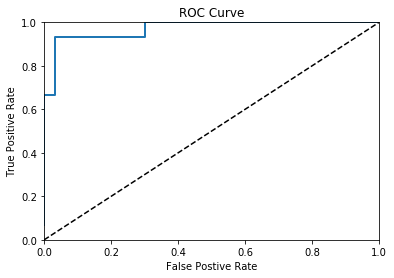

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

plt.plot(fpr, tpr, linewidth = 2)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [17]:
roc_auc_score(y_test, y_test_prob)

0.97111111111111115

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
scores = cross_val_score(cv=5, scoring="accuracy", estimator=lr, X=X_train, y= y_train)
scores.mean(), scores.std()

(0.95238095238095233, 0.0)

Now, let's use all features availabe to predict the class.

In [20]:
X = iris.values[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
print(X_train.shape)
lr = LogisticRegression(C = 10)
scores = cross_val_score(cv=5, scoring="accuracy", estimator=lr, X=X_train, y= y_train)
scores.mean(), scores.std()

(105, 4)


(0.96277056277056272, 0.045617107782924646)

### Regularization of model using complexity parameter

In [21]:
params = 10 ** np.linspace(-5, 5, 100)
means, stds = [], []
coefs = []

for p in params:
    lr = LogisticRegression(C = p)
    scores = cross_val_score(cv=5, scoring="accuracy", estimator=lr, X=X_train, y= y_train)
    means.append(scores.mean())
    stds.append(scores.std())
    lr.fit(X_train, y_train)
    coefs.append(lr.coef_[0])

means = np.array(means)
stds = np.array(stds)

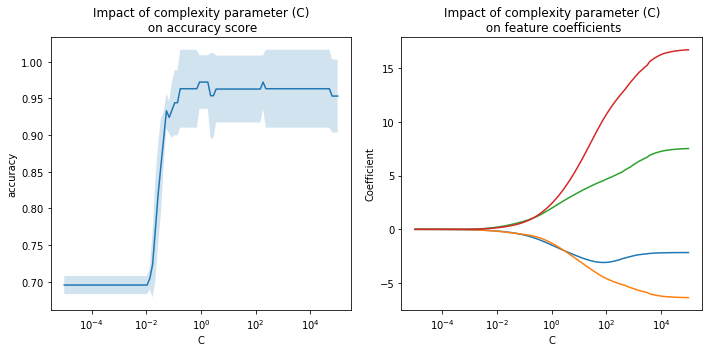

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(params, means)
plt.fill_between(params, means + stds, means - stds, alpha = 0.2)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.title("Impact of complexity parameter (C)\n on accuracy score")

plt.subplot(1, 2, 2)
plt.plot(params, coefs)
plt.xlabel("C")
plt.ylabel("Coefficient")
plt.xscale("log")
plt.title("Impact of complexity parameter (C)\n on feature coefficients")

plt.tight_layout()

In [23]:
lr = LogisticRegression(C = 10)
lr.fit(X_train, y_train)
lr.coef_[0]

array([-2.55602202, -2.94041318,  3.46598289,  6.02582653])

In [24]:
lr = LogisticRegression(C = 1e-4)
lr.fit(X_train, y_train)
lr.coef_[0]

array([-0.0083705 , -0.00582954, -0.00115182,  0.00056174])

### Model Tuning using Grid Search Techqniue

Find which parameters are available to tune.

In [25]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid ={"C": 10 ** np.linspace(-5, 5, 100)}
gs = GridSearchCV(cv=5, estimator = lr, scoring="accuracy", param_grid= param_grid)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.26186e-05, ...,   7.92483e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [28]:
best = gs.best_estimator_
print("Best estimator score: ", best.score(X_test, y_test))
print(best.coef_[0])

Best estimator score:  1.0
[-1.40551558 -1.21892696  1.89206965  2.27884484]


In [29]:
gs.best_params_

{'C': 0.89021508544503924}

# Nonlinear Decision Boundary using Logistic Regression

(150, 2) (150,)
Acuracy score:  0.96


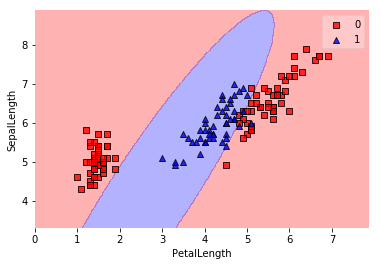

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.pipeline import Pipeline

y = np.where(iris.Species == "Iris-versicolor", 1, 0)
X = iris.loc[:, ["PetalLength","SepalLength"]].values
print(X.shape, y.shape)
lr = LogisticRegression()
poly = PolynomialFeatures(degree=2)

pipeline = Pipeline([("poly", poly), ("lr", lr)])

pipeline.fit(X, y)

plot_decision_regions(X, y, pipeline)
plt.xlabel("PetalLength")
plt.ylabel("SepalLength")

print("Acuracy score: ", lr.score(poly.transform(X), y))

## Multi Class classification

In [31]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [32]:
X = iris.iloc[:, 0:4].values
y = iris.Species.values
scaler = StandardScaler()
X_std = scaler.fit_transform(X) 
pd.DataFrame(X_std).head()

,0,1,2,3
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [33]:
le = LabelEncoder()
y = le.fit_transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 100)

In [35]:
lr = LogisticRegression(max_iter=100, random_state=100)

param_grid = [
    {"C": 10 ** np.linspace(-5, 5, 100)}
]
gs = GridSearchCV(cv=5, estimator = lr, scoring="accuracy", param_grid= param_grid)
gs.fit(X_train, y_train)
gs.best_params_

{'C': 23.101297000831579}

In [36]:
lr = gs.best_estimator_
lr.intercept_, lr.coef_

(array([-3.16898056, -0.753681  , -7.42016236]),
 array([[-1.02848129,  2.5037609 , -2.73071943, -2.64698775],
        [ 0.4464633 , -1.60984692,  0.77761392, -1.17260505],
        [-0.71255595, -0.76267791,  6.045267  ,  5.84569189]]))

In [37]:
coeffs = pd.DataFrame(np.hstack([lr.intercept_.reshape(-1, 1), lr.coef_]))
coeffs.columns = ["intercept", *iris.columns[0:4]]
coeffs

,intercept,SepalLength,SepalWidth,PetalLength,PetalWidth
0,-3.168981,-1.028481,2.503761,-2.730719,-2.646988
1,-0.753681,0.446463,-1.609847,0.777614,-1.172605
2,-7.420162,-0.712556,-0.762678,6.045267,5.845692


In [38]:
accuracy_score(y_test, lr.predict(X_test))

0.93333333333333335

## Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
X = iris.iloc[:, [2,0]].values
y = iris.Species.values
scaler = StandardScaler()
X_std = scaler.fit_transform(X) 
pd.DataFrame(X_std).head()
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 100)
print(X_train.shape)

(105, 2)


In [41]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

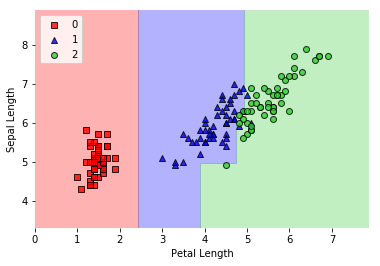

In [42]:
plot_decision_regions(X, y, tree)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")

In [43]:
tree.score(X_test, y_test)

0.9555555555555556

#### Show the tree

You need to install a software graphviz. On centos it is available in standard yum repo.

In [44]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file = "tree.dot", feature_names = ["PetalLength","SepalLength"])

Convert the .dot file into a png

In [45]:
!dot -Tpng tree.dot -o tree.png

/bin/sh: dot: command not found


We used 2 parameters for model training because we wanted to plot the decision region. Let's retrain the model using all features and compare the performance with logistic regression.

In [46]:
X = iris.iloc[:, 0:4].values
y = iris.Species.values
X_std = scaler.fit_transform(X)
tree = DecisionTreeClassifier(max_depth=4)
mean_cv_accuracy = np.mean(cross_val_score(cv = 5, estimator=tree, X=X_std, y=y))
print("Mean accuracy using all features over full dataset: ", mean_cv_accuracy)

Mean accuracy using all features over full dataset:  0.96


We got above the accuracy of the tuned model using logistic regression 95.56. We can run tuning over tree max_depth and other parameters to tune the model.

In [47]:
tuning_grid = {"max_depth": np.arange(1, 10)}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(cv=5, estimator=tree, param_grid=tuning_grid, scoring="accuracy")
grid_search.fit(X_std, y)
grid_search.best_score_, grid_search.best_params_

(0.97333333333333338, {'max_depth': 3})

After tuning we got a better result 0.9733.

### Random Forest Classifier

In [48]:
X = iris.iloc[:, [2,0]].values
y = iris.Species.values
scaler = StandardScaler()
X_std = scaler.fit_transform(X) 
pd.DataFrame(X_std).head()
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 100)
print(X_train.shape)

(105, 2)


Accuracy: 0.955555555556


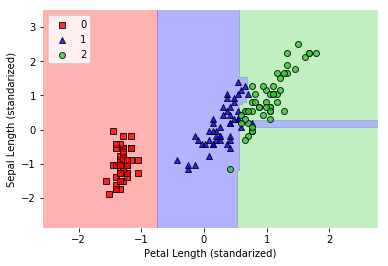

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=4, random_state=123)
forest.fit(X_train, y_train)
print("Accuracy:", forest.score(X_test, y_test))
plot_decision_regions(X_std, y, forest)
plt.xlabel("Petal Length (standarized)")
plt.ylabel("Sepal Length (standarized)")
plt.legend(loc = "upper left")

## SVM Classifier

In [50]:
from sklearn.svm import SVC

In [51]:
X = iris.iloc[:, [2,0]].values
y = iris.Species.values
scaler = StandardScaler()
X_std = scaler.fit_transform(X) 
pd.DataFrame(X_std).head()
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 100)
print(X_train.shape)

(105, 2)


accuracy 0.977777777778


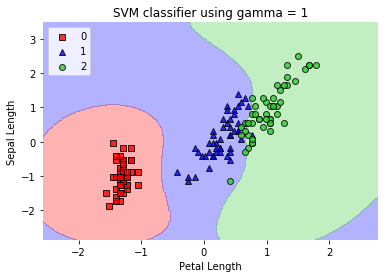

In [52]:
svc = SVC(gamma=1, C =1, kernel="rbf", random_state=345)
svc.fit(X_train, y_train)
print("accuracy", svc.score(X_test, y_test))
plot_decision_regions(X_std, y, svc)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")
plt.title("SVM classifier using gamma = 1")

accuracy 0.977777777778


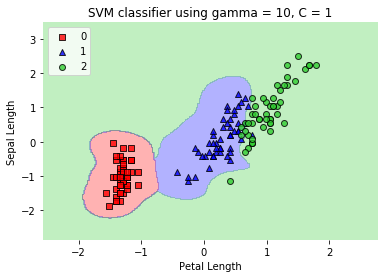

In [53]:
svc = SVC(gamma=10, C = 1, kernel="rbf", random_state=345)
svc.fit(X_train, y_train)
print("accuracy", svc.score(X_test, y_test))
plot_decision_regions(X_std, y, svc)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")
plt.title("SVM classifier using gamma = 10, C = 1")

accuracy 1.0


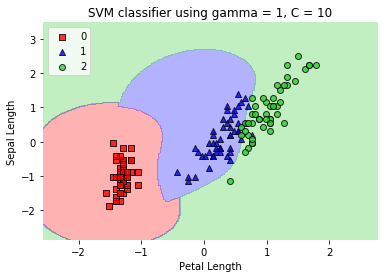

In [54]:
svc = SVC(gamma=1, C = 10, kernel="rbf", random_state=345)
svc.fit(X_train, y_train)
print("accuracy", svc.score(X_test, y_test))
plot_decision_regions(X_std, y, svc)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")
plt.title("SVM classifier using gamma = 1, C = 10")

Above we see the impact of different gamma and C values. Higher the gamma value or C values, each observation seems to loose territory of influence and hence tend to create a more overfit model. But we see the accuracy score is already matched with some of the best we have got so far. Let retrain the model using all features and tune the model using parameter grid.

accuracy 0.977777777778


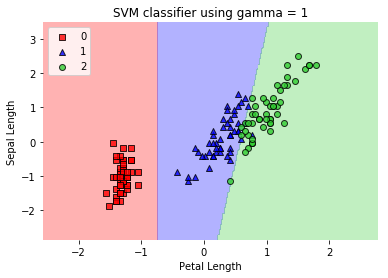

In [55]:
svc = SVC(C=10, kernel="linear", random_state=345)
svc.fit(X_train, y_train)
print("accuracy", svc.score(X_test, y_test))
plot_decision_regions(X_std, y, svc)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")
plt.title("SVM classifier using gamma = 1")

accuracy 0.911111111111


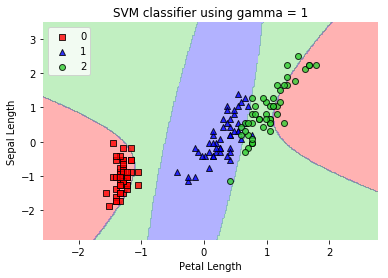

In [56]:
svc = SVC(C=10, kernel="poly", degree=2, random_state=345)
svc.fit(X_train, y_train)
print("accuracy", svc.score(X_test, y_test))
plot_decision_regions(X_std, y, svc)
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")
plt.legend(loc = "upper left")
plt.title("SVM classifier using gamma = 1")

In [57]:
SVC().get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [58]:
%%time
param_grid = {
    "C": 10 ** np.linspace(-2, 2, 10),
    "gamma": 10 ** np.linspace(-1, 2, 10),
    "kernel": ["linear", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(cv = 5, estimator=SVC(), 
                           param_grid=param_grid, scoring="accuracy", verbose=True)
grid_search.fit(X_std, y)
print("Best score(CV): ", grid_search.best_score_, 
      "\n Best parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best score(CV):  0.96 
 Best parameters:  {'C': 4.6415888336127775, 'gamma': 1.0, 'kernel': 'rbf'}
CPU times: user 2.76 s, sys: 12.8 ms, total: 2.77 s
Wall time: 2.78 s


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    2.8s finished


In [59]:
np.set_printoptions(suppress=True)
10 ** np.linspace(-5, 5, 10)

array([      0.00001   ,       0.00012915,       0.0016681 ,
             0.02154435,       0.27825594,       3.59381366,
            46.41588834,     599.48425032,    7742.63682681,  100000.        ])

# Credit Default Dataset

In [60]:
credit = pd.read_csv("https://raw.githubusercontent.com/abulbasar/data/master/credit-default.csv")
credit.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


In [61]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_length       1000 non-null object
installment_rate        1000 non-null int64
personal_status         1000 non-null object
other_debtors           1000 non-null object
residence_history       1000 non-null int64
property                1000 non-null object
age                     1000 non-null int64
installment_plan        1000 non-null object
housing                 1000 non-null object
existing_credits        1000 non-null int64
default                 1000 non-null int64
dependents              1000 non-null int64
telephone               1000 non-null object
foreign_worker          1000 non-null object
jo

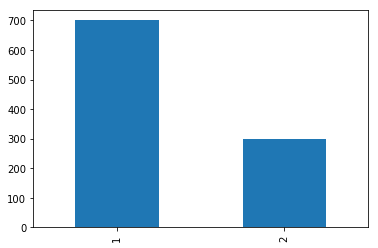

In [62]:
credit.default.value_counts().plot.bar()

In [63]:
categorical_columns = credit.select_dtypes(["O"]).columns
categorical_columns

Index(['checking_balance', 'credit_history', 'purpose', 'savings_balance',
       'employment_length', 'personal_status', 'other_debtors', 'property',
       'installment_plan', 'housing', 'telephone', 'foreign_worker', 'job'],
      dtype='object')

In [64]:
default_status = credit.default
del credit["default"]

In [65]:
credit_dummied = pd.get_dummies(credit, columns=categorical_columns, drop_first=True)
credit_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 48 columns):
months_loan_duration                     1000 non-null int64
amount                                   1000 non-null int64
installment_rate                         1000 non-null int64
residence_history                        1000 non-null int64
age                                      1000 non-null int64
existing_credits                         1000 non-null int64
dependents                               1000 non-null int64
checking_balance_< 0 DM                  1000 non-null uint8
checking_balance_> 200 DM                1000 non-null uint8
checking_balance_unknown                 1000 non-null uint8
credit_history_delayed                   1000 non-null uint8
credit_history_fully repaid              1000 non-null uint8
credit_history_fully repaid this bank    1000 non-null uint8
credit_history_repaid                    1000 non-null uint8
purpose_car (new)                       

In [66]:
scaler = StandardScaler()
X = scaler.fit_transform(credit_dummied.values.astype(np.float64))
y = np.where(default_status == 1.0, 1, 0)

In [67]:
lr = LogisticRegression(C = 1, random_state=100)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.97777777777777775

In [68]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=123)
tree.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 123,
 'splitter': 'best'}

Find the best parameters (consider max_depth) for the decision tree
model to solve the credit default problem.

In [69]:
from sklearn.model_selection import GridSearchCV
tuning_grid = {
    "max_depth": range(1, 10),
    "max_leaf_nodes": range(2, 20)
}
gs = GridSearchCV(cv=5, estimator=tree, 
                  param_grid=tuning_grid, scoring="accuracy", verbose=True)

gs.fit(X, y)
print("Best params: ", gs.best_params_, "Best score: ", gs.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params:  {'max_depth': 7, 'max_leaf_nodes': 14} Best score:  0.745


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:    2.5s finished
